In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests

In [3]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [4]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

In [5]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

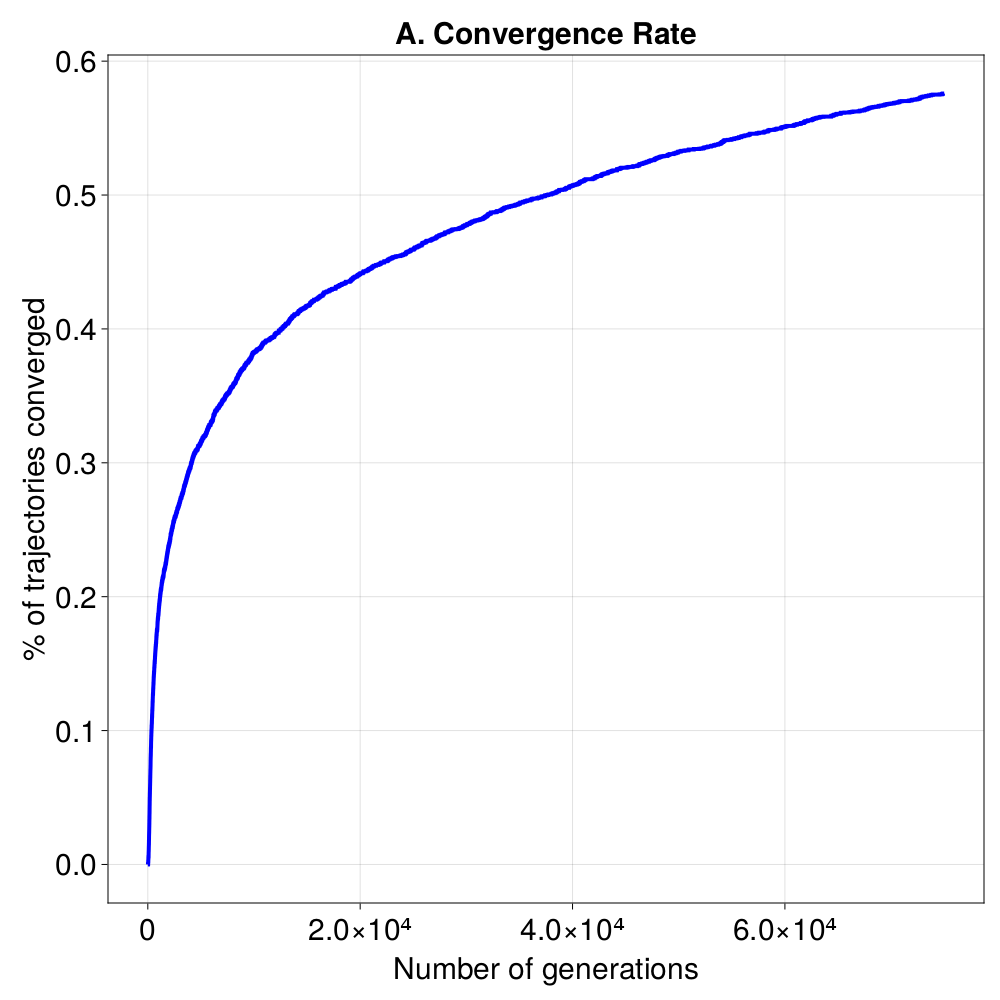

In [6]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [7]:
cum_conv[end]

0.5758

In [8]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);

In [9]:
sim_m = copy(data["fund_dmat_cell"])
conv = copy(data["converged"]);

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];


In [10]:
countmap(class_labels)

Dict{String, Int64} with 5 entries:
  "bistable"      => 326
  "feed_forward"  => 25
  "classical"     => 1428
  "mutual_inh"    => 33
  "No assignment" => 1067

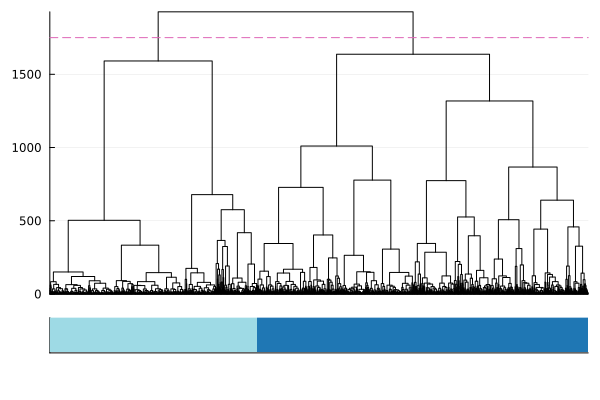

In [11]:
cu_thresh =  1750

hc1 = hclust(dmat_av[conv,conv],linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [12]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

In [13]:
conv_time = map(x->length(x),fitness_traj_b) 
conv_time_n = conv_time / maximum(conv_time);

In [14]:
# CairoMakie.boxplot(clust_labels, conv_time)

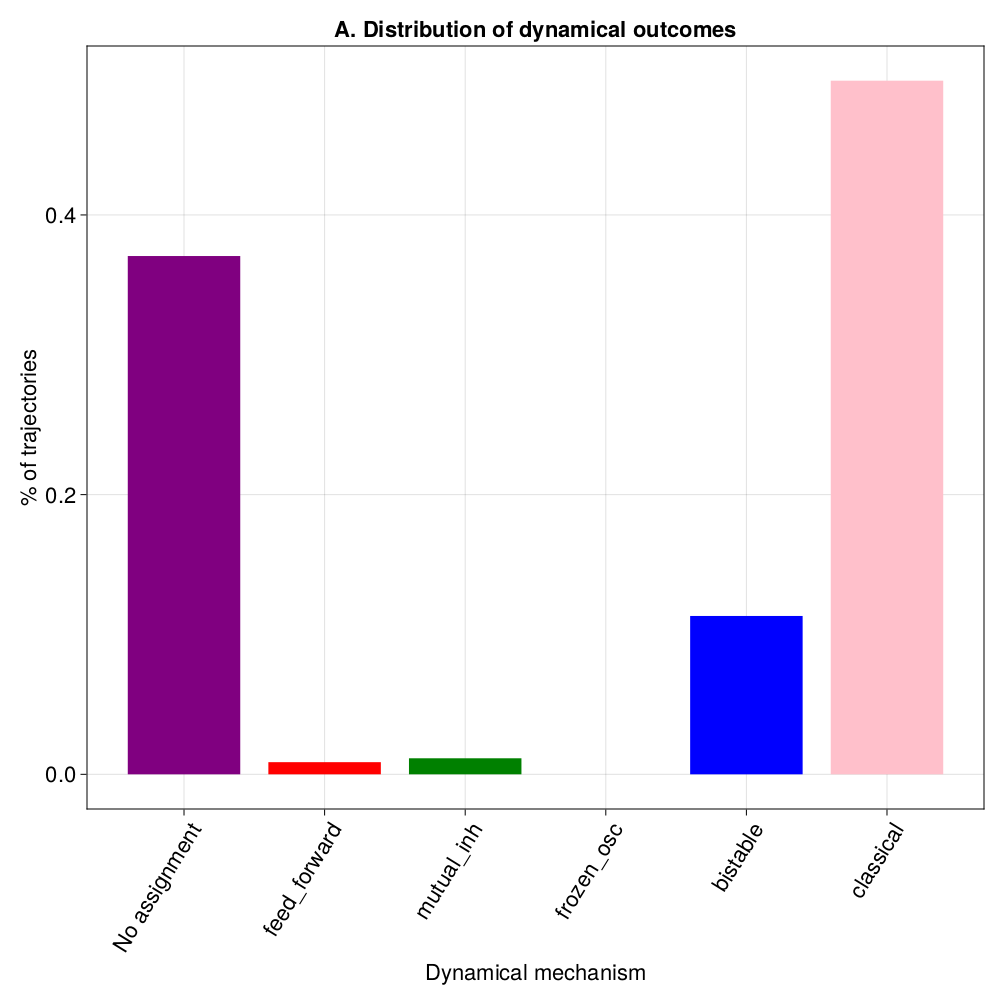

In [15]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Distribution of dynamical outcomes",xlabel = "Dynamical mechanism",ylabel = "% of trajectories")

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for (n,i) in enumerate([class_labels])

    r_ms2_cm = countmap(i)

    count_v = zeros(length(fundamental_topologies)+1)

    for (i,nm) in enumerate(fundamental_topologies)
        if haskey(r_ms2_cm,nm)
            count_v[i+1] = r_ms2_cm[nm]
        else
            count_v[i+1] = 0
        end
    end

    if haskey(r_ms2_cm,"No assignment")
        count_v[1] = r_ms2_cm["No assignment"]
    else
        count_v[1] = 0
    end

    count_v = count_v ./ sum(count_v)

    # r_ms3 = reduce(vcat,r[:fitness_delta]);

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(n) for _ in 1:length(count_v)])
    push!(pos_list,collect(1:length(count_v)))
    push!(color_list,[cp[x] for x in 1:length(count_v)])

    # CairoMakie.density!(ax3,filter(x->x < 1,r_ms3), color = (cp[fund_top_ndict[i]+1],0.5),offset =  -(fund_top_ndict[i]+1))
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax,xs,ys,dodge = dodge,color = bar_cl)

ax.xticks = (1:6,[fund_top_dict[x] for x in 0:5])

# ax.xticklabelcolor = (1:6,[cp[x+1] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","DynOutcomes.png"),fig,cond)

fig

In [16]:
count_v_list

1-element Vector{Any}:
 [0.370614796804446, 0.00868357068426537, 0.011462313303230288, 0.0, 0.11323376172282042, 0.49600555748523795]

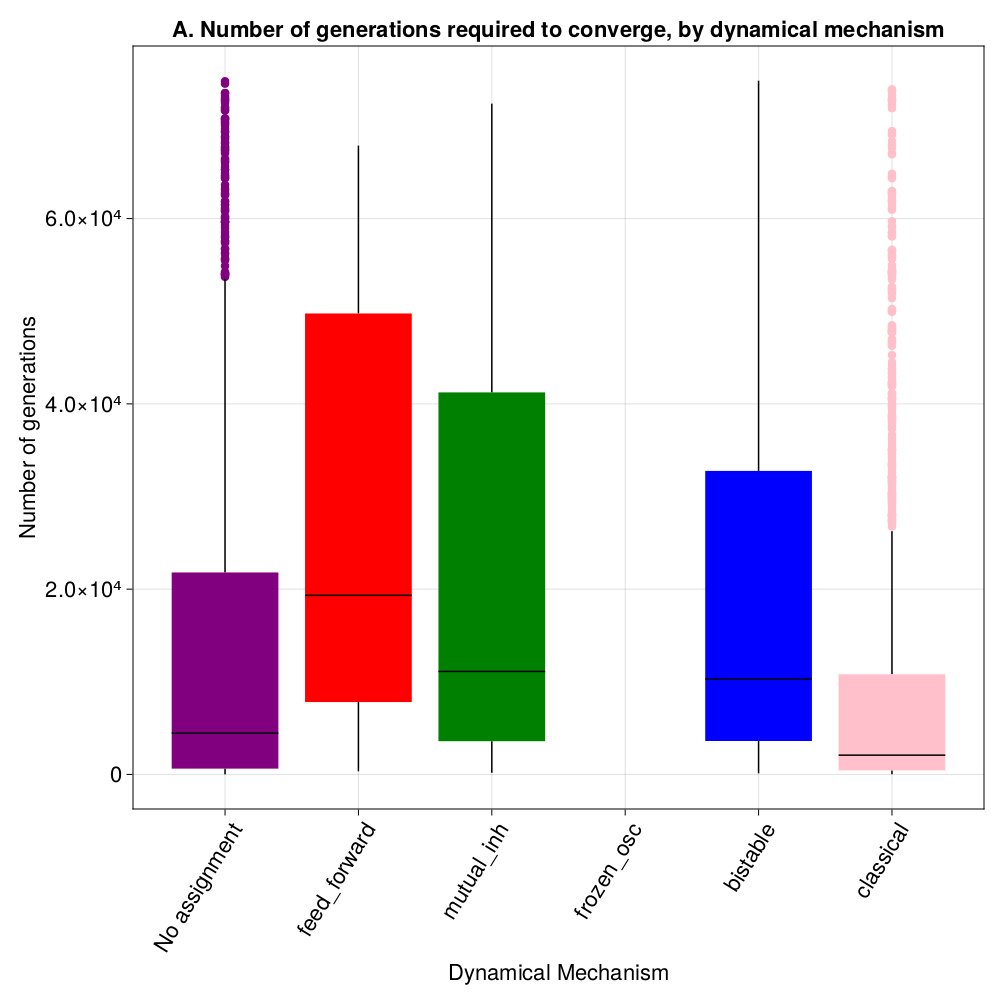

In [17]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Number of generations required to converge, by dynamical mechanism",xlabel = "Dynamical Mechanism",ylabel = "Number of generations")

CairoMakie.boxplot!(ax,map(x->fund_top_ndict[x],class_labels), conv_time, color = map(x->cp[fund_top_ndict[x]+1],class_labels))

ax.xticks = (0:5,[fund_top_dict[x] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","ConvergenceRateComparison.png"),fig,cond)

fig

In [19]:
geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

In [20]:
function get_mutant_n_dist(g_traj)
    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    return sum(g_traj_diff .!= 0.,dims = 1)[1,:]
end

function get_mutant_dist(g_traj)
    g_traj_diff = (g_traj[:,2:end] .- g_traj[:,1:end-1]) ./ map(x-> x == 0 ? 1. : x, g_traj[:,1:end-1])
    
    return [filter(x->x .!= 0.,v) for v in eachcol(g_traj_diff)]
end

function get_fitness_delta(f_traj)
    f_traj_diff = f_traj[2:end] .- f_traj[1:end-1]
    return f_traj_diff
end

function get_mutation_id(g_traj)

    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    mut_id = [findall(x-> x .!= 0, y) for y in eachcol(g_traj_diff)]

    return mut_id
end


weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

In [21]:
fitness_traj = map(t->map(x->x[2]+x[1],t),fitness_traj_b);

In [22]:
initial_fitness = fitness_traj[1][1]

-0.9985165945734575

In [23]:
ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [24]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];


In [25]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

In [26]:
clust_labels = copy(class_labels);

In [27]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->unique(x)[1:end-1],fitness_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label_af = [[(fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [28]:
function condition_data(return_var,condition_var,condition_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

function condition_data_incl(return_var,condition_var,condition_values,incl_var,incl_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]) & all([value ∈ x[var] for (var,value) in zip(incl_var,incl_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

condition_data_incl (generic function with 1 method)

In [29]:
class_labels_u = unique(class_labels)

5-element Vector{String}:
 "classical"
 "bistable"
 "No assignment"
 "mutual_inh"
 "feed_forward"

In [30]:
fundamental_topologies

5-element Vector{String}:
 "feed_forward"
 "mutual_inh"
 "frozen_osc"
 "bistable"
 "classical"

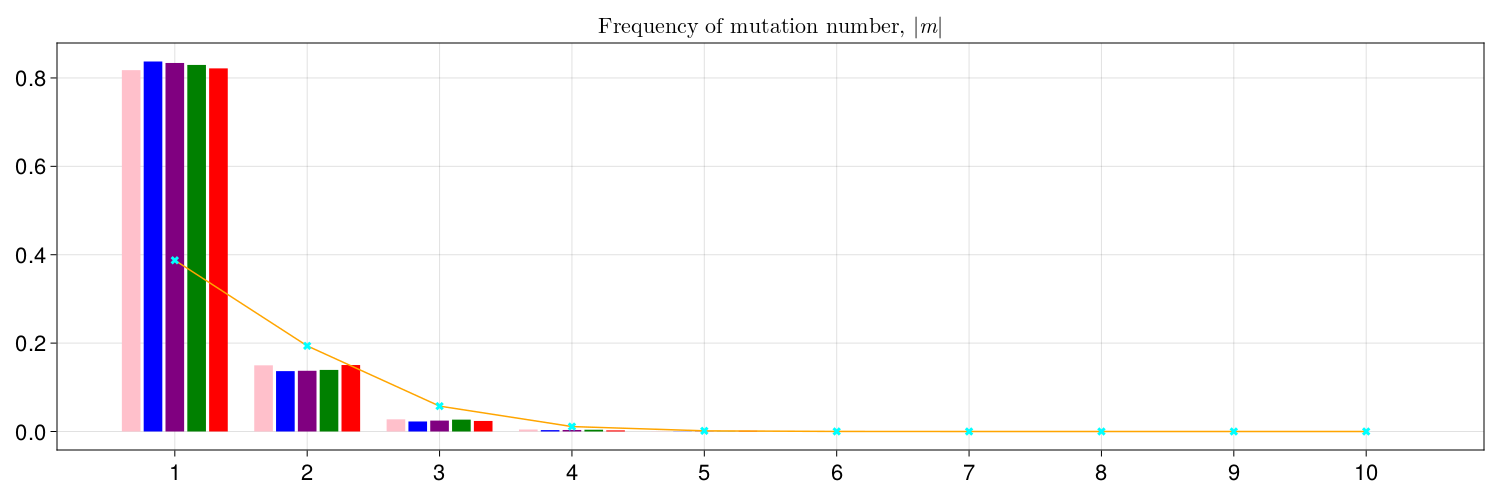

In [31]:
fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
# ax1 = Axis(fig[1,1],title = L"\text{Distribution of mutation size, } ||m||")
ax2 = Axis(fig[1,1],title = L"\text{Frequency of mutation number, } |m|")
# ax3 = Axis(fig[1,3],title = L"\text{Distribution of fitness changes, } \Delta f")

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for (n,i) in enumerate(class_labels_u)

    r = condition_data((:mut_size,:fitness_delta),[:cluster_id],[i],all_mut_info)
    r_ms1 = reduce(vcat,map(x->sum(x .* x),r[:mut_size]))
    r_ms2 = reduce(vcat,map(x->length(x),r[:mut_size]));

    r_ms2_cm = countmap(r_ms2)

    count_v = zeros(10)

    for nm in 1:10
        if haskey(r_ms2_cm,nm)
            count_v[nm] = r_ms2_cm[nm]
        else
            count_v[nm] = 0
        end
    end

    count_v = count_v ./ sum(count_v)

    r_ms3 = reduce(vcat,r[:fitness_delta]);

    # CairoMakie.density!(ax1,filter(x->x < 1,r_ms1), color = (cp[fund_top_ndict[i]+1],0.5),offset = -(fund_top_ndict[i]))

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(n) for _ in 1:10])
    push!(pos_list,collect(1:10))
    push!(color_list,[cp[fund_top_ndict[i]+1] for _ in 1:10])

    # CairoMakie.density!(ax3,filter(x->x < 1,r_ms3), color = (cp[fund_top_ndict[i]+1],0.5),offset =  -(fund_top_ndict[i]+1))
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax2,xs,ys,dodge = dodge, color = bar_cl)

binomialp(k,p,n) = (factorial(n)/(factorial(k)*factorial(n-k)))*(p^k)*((1-p)^(n-k))

n_trials = 10

CairoMakie.lines!(ax2,[binomialp(k,mut_prob,n_trials) for k in 1:n_trials],color = :orange)
CairoMakie.scatter!(ax2,[binomialp(k,mut_prob,n_trials) for k in 1:n_trials],color = :cyan, marker = :x)

ax2.xticks = (1:10,string.(1:10))

cond_save(plotsdirx("Experiment_1","Mutation_number.png"),fig,cond)

fig

In [32]:
all_mut_info[1]

(traj_id = 1, cluster_id = "classical", fitness_delta = 0.28350780633005224, fitness_bin = 1, fitness = -0.9985165945734575, mut_size = [1.2944900116518976, 2.379949492671237], mut_type = Any[:existing, :new], n_mut = 2, mut_id_name = "A=>C|C=>C", mut_id = [3, 9])

In [33]:
r = condition_data_incl((:mut_size,:mut_type,:mut_id),[:cluster_id],["classical"],[:mut_id],[1],all_mut_info)
r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==1,x)[1],r[:mut_id]),r[:mut_size])]
r_ms_t = [x[n] for (n,x) in zip(map(x->findall(x->x==1,x)[1],r[:mut_id]),r[:mut_type])]
d = r_ms[r_ms_t .== :new]

639-element Vector{Float64}:
  0.03487156347189213
  1.5616517772735072
  5.057624850478106
  1.1471587083783934
  0.006575371085915549
 -5.289669360708138
  0.7874880551778567
 -0.04973175295708643
  0.617790099052062
  0.887221381764336
  ⋮
  0.007023018881431753
  0.014665910659312331
  0.09631150743991235
  0.011309323031326812
  0.1317941059611787
  0.06404868855527823
  0.030770615560438586
  0.21877614181885363
  0.026898512152289555

In [34]:
weight_indices = Tuple.(findall(viable_mutations .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
for (n,i) in enumerate(class_labels_u)

    fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 30.,title = i)
    
    ax_list = []

    for wi in 1:length(weight_indices)

        ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Mutation size", ylabel="Frequency", title = weight_names[wi]) 

        r = condition_data_incl((:mut_size,:mut_type,:mut_id),[:cluster_id],[i],[:mut_id],[wi],all_mut_info)
        r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]
        r_ms_t = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_type])]
        d = r_ms[r_ms_t .== :new]

        if length(d) > 0

            test_p = pvalue(ExactOneSampleKSTest(d, mutation_op.noise_distribution))

            d_min = minimum(d)
            d_max = maximum(d)

            trange = LinRange(d_min,d_max,1000)

            npdf = [pdf(mutation_op.noise_distribution,t) for t in trange]

            # CairoMakie.text!(ax1,Point2f(d_min,1.),text = "p_value = " * string(test_p))

            CairoMakie.hist!(ax1,d,color = (cp[fund_top_ndict[i]+1],0.5),bins = 30,normalization = :pdf)
            # CairoMakie.lines!(ax1,trange,npdf,color = :black)

            push!(ax_list,ax1)

        end

    end

    cond_save(plotsdirx("Experiment_1","Mutation_sizes_uniform" * string(i) * ".png"),fig,cond)

end


In [35]:
# fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

# color_scheme = palette(:tab10)

# weight_indices = Tuple.(findall(ones(3,4) .> 0));

# vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

# weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
# ax_list = []

# cl = "classical"

# for wi in 1:10

#     ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Fitness", ylabel=L"\Delta W", title = weight_names[wi])

#     r = condition_data_incl((:mut_size,:mut_id,:cluster_id,:fitness,:fitness_delta),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)
#     r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]

#     r_cl = reduce(vcat,r[:cluster_id]);
#     r_fitness = reduce(vcat,r[:fitness]);
#     r_fitness_delta = reduce(vcat,r[:fitness_delta]);

#     color_cl = map(x->color_scheme[x],r_cl)

#     CairoMakie.scatter!(ax1,r_fitness,r_ms,color = [(c,o) for (c,o) in zip(color_cl,r_fitness_delta/maximum(r_fitness_delta))])
#     # CairoMakie.scatter!(ax1,r_fitness,r_ms,color = color_cl)

#     push!(ax_list,ax1)

# end

# linkxaxes!(ax_list...)

# fig

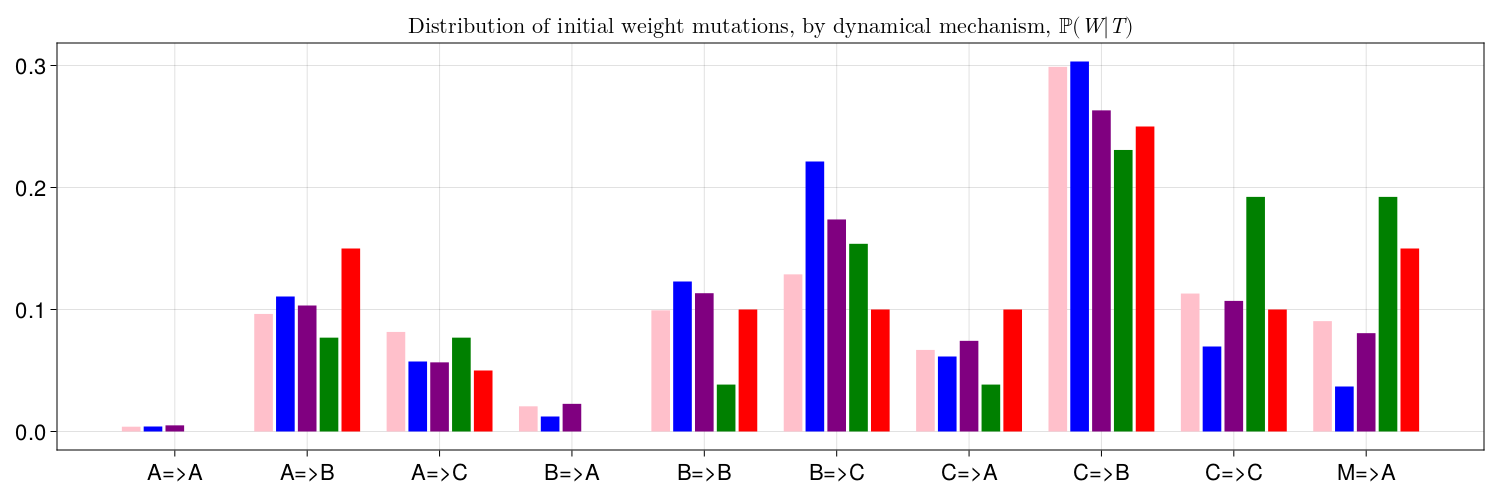

In [36]:
fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
ax1 = Axis(fig[1,1],title = L"\text{Distribution of initial weight mutations, by dynamical mechanism, } \mathbb{P}(W | T)")

n_mut = 1

count_v_list = []
count_vb_list = []
dodge_list = []
pos_list = []
color_list = []

# top_order = unique(clust_labels)

bl = condition_data((:fitness,:traj_id),[:fitness_bin,:n_mut],[1,n_mut],all_mut_info)

n_traj_bl = length(unique(reduce(vcat,bl[:traj_id]))) 

for (n,i) in enumerate(class_labels_u)

    # print(i)

    count_v = zeros(10)
    count_vb = zeros(10)

    rt = condition_data((:fitness,:traj_id),[:fitness_bin,:n_mut,:cluster_id],[1,n_mut,i],all_mut_info)

    n_traj_t = length(unique(rt[:traj_id]))

    pt = n_traj_t / n_traj_bl

    for wi in 1:10
        # print(wi)
        r = condition_data((:fitness,:traj_id),[:fitness_bin,:cluster_id,:n_mut,:mut_id],[1,i,n_mut,[wi]],all_mut_info)

        rw = condition_data((:fitness,:traj_id),[:fitness_bin,:n_mut,:mut_id],[1,n_mut,[wi]],all_mut_info)

        n_traj_w = length(unique(rw[:traj_id]))

        if length(r[:traj_id]) > 0
            count_v[wi] = length(unique(r[:traj_id])) / n_traj_t
        else
            count_v[wi] = 0
        end

        pwi = n_traj_w  / n_traj_bl 

        count_vb[wi] = count_v[wi]*pt/pwi
    end

    count_v = count_v ./ sum(count_v)
    count_vb = count_vb ./ sum(count_vb)

    push!(count_v_list,count_v)
    push!(count_vb_list,count_vb)
    push!(dodge_list,[Int(n) for _ in 1:10])
    push!(pos_list,collect(1:10))
    push!(color_list,[cp[fund_top_ndict[i]+1] for _ in 1:10])
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
ysb = reduce(vcat,count_vb_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax1,xs,ys,dodge = dodge, color = bar_cl)
ax1.xticks = (1:10,weight_names[1:10])

cond_save(plotsdirx("Experiment_1","FirstWeightMutation.png"),fig,cond)

fig

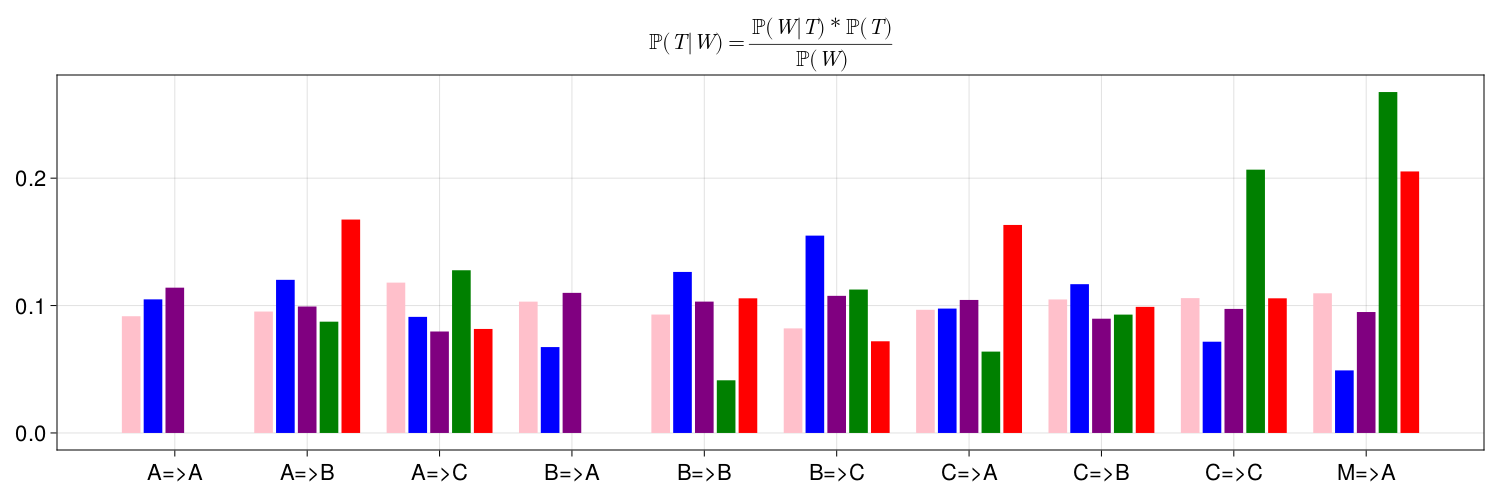

In [37]:
fig = CairoMakie.Figure(resolution = (1500,500),fontsize = 22.)
ax1 = Axis(fig[1,1],title = L"\mathbb{P}(T | W) = \frac{\mathbb{P}(W | T) * \mathbb{P}(T)}{\mathbb{P}(W)} ")

CairoMakie.barplot!(ax1,xs,ysb,dodge = dodge, color = bar_cl)
ax1.xticks = (1:10,weight_names[1:10])

cond_save(plotsdirx("Experiment_1","FirstWeightMutationCond.png"),fig,cond)

fig

In [38]:
using PyCall

In [39]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

PyObject <module 'pandas' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/pandas/__init__.py'>

In [65]:
r = condition_data((:mut_id,:cluster_id),[:fitness_bin,:n_mut],[1,1],all_mut_info);

In [66]:
mut_id = map(x->weight_names[x],reduce(vcat,r[:mut_id]))

clust_id =r[:cluster_id]

d = pd.DataFrame(Dict("Weight" => mut_id, "Topology" => clust_id))

d

,Topology,Weight
0,bistable,C=>B
1,classical,B=>B
2,classical,B=>C
3,classical,C=>B
4,No assignment,B=>C
...,...,...
2096,bistable,M=>A
2097,No assignment,M=>A
2098,No assignment,C=>A
2099,classical,C=>B


In [67]:
pd.crosstab(d["Weight"],d["Topology"])

Topology,No assignment,bistable,classical,feed_forward,mutual_inh
Weight,,,,,
A=>A,4,1,4,0,0
A=>B,82,27,98,3,2
A=>C,45,14,83,1,2
B=>A,18,3,21,0,0
B=>B,90,30,101,2,1
B=>C,138,54,131,2,4
C=>A,59,15,68,2,1
C=>B,209,74,304,5,6
C=>C,85,17,115,2,5


In [46]:
color_name = ["purple","red","green","yellow","blue","pink"]
color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 5 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "mutual_inh"    => "green"
  "No assignment" => "purple"

In [68]:
props = key -> Dict("color" => color_dict[key[2]])
labelizer = key -> ""
props(("A=>A","classical"))

Dict{String, String} with 1 entry:
  "color" => "pink"

In [74]:
d_all = pd.DataFrame(Dict("Weight" => ["All" for _ in mut_id], "Topology" => clust_id))



d_en = pd.concat([d,d_all])

,Topology,Weight
0,bistable,C=>B
1,classical,B=>B
2,classical,B=>C
3,classical,C=>B
4,No assignment,B=>C
...,...,...
2096,bistable,All
2097,No assignment,All
2098,No assignment,All
2099,classical,All


In [75]:
fig = statmod.mosaic(d_en,["Weight","Topology"],properties = props,labelizer = labelizer,label_rotation = 90)

plt.show()

In [84]:
all_mut_info

150273-element Vector{NamedTuple{(:traj_id, :cluster_id, :fitness_delta, :fitness_bin, :fitness, :mut_size, :mut_type, :n_mut, :mut_id_name, :mut_id), Tuple{Int64, String, Float64, Int64, Float64, Vector{Float64}, Vector{Any}, Int64, String, Vector{Int64}}}}:
 (traj_id = 1, cluster_id = "classical", fitness_delta = 0.28350780633005224, fitness_bin = 1, fitness = -0.9985165945734575, mut_size = [1.2944900116518976, 2.379949492671237], mut_type = [:existing, :new], n_mut = 2, mut_id_name = "A=>C|C=>C", mut_id = [3, 9])
 (traj_id = 1, cluster_id = "classical", fitness_delta = 0.10500009964904344, fitness_bin = 3, fitness = -0.7150087882434053, mut_size = [0.42599171753119275], mut_type = [:existing], n_mut = 1, mut_id_name = "M=>A", mut_id = [10])
 (traj_id = 1, cluster_id = "classical", fitness_delta = 2.4830150602284107e-8, fitness_bin = 3, fitness = -0.6100086885943619, mut_size = [-6.833322146312966], mut_type = [:new], n_mut = 1, mut_id_name = "C=>B", mut_id = [8])
 (traj_id = 1, clu

In [82]:
r = condition_data((:n_mut,:cluster_id),[:fitness_bin],[1],all_mut_info);

d = pd.DataFrame(Dict("N_mut" => r[:n_mut], "Topology" => r[:cluster_id]))

d_all = pd.DataFrame(Dict("Weight" => ["All" for _ in r[:n_mut]], "Topology" => r[:cluster_id]))

d_en = pd.concat([d,d_all])

fig = statmod.mosaic(d_en,["N_mut","Topology"],properties = props,labelizer = labelizer,label_rotation = 90)

plt.show()

d

,Topology,N_mut
0,classical,2
1,classical,2
2,bistable,1
3,classical,1
4,classical,1
...,...,...
2874,classical,2
2875,No assignment,1
2876,No assignment,1
2877,classical,1


In [94]:
r = condition_data((:fitness_delta,:fitness,:cluster_id),[],[],all_mut_info);

In [97]:
r[:cluster_id]

150273-element Vector{String}:
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 ⋮
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"
 "classical"

In [49]:
# # result = zeros(10,n_bin-1)

# result = zeros(10,length(unique(clust_labels)))

# r_ms_list = []

# for wi in 1:10
#     for cl in unique(clust_labels)

#         r = condition_data_incl((:mut_size,:mut_id,:fitness_delta,:fitness,:cluster_id),[:cluster_id],[cl],[:mut_id],[wi],all_mut_info)

#         r_fitness_delta = reduce(vcat,r[:fitness_delta]);

#         label = reduce(vcat,r[:cluster_id])

#         r_ms = [x[n] for (n,x) in zip(map(x->findall(x->x==wi,x)[1],r[:mut_id]),r[:mut_size])]

#         test_p = pvalue(ExactOneSampleKSTest(r_ms, mutation_op.noise_distribution))

#         result[wi,cl] = test_p

#         push!(r_ms_list,r_ms)
#     end
# end

In [50]:
# using PyCall

# phate = pyimport("phate")

# phate_op = phate.PHATE(k = 100,n_jobs = -2, gamma=0)

# rescale(A; dims=1) = (A .- mean(A, dims=dims)) ./ max.(std(A, dims=dims), eps())

# # X = rescale(data["dmat_X_av"][:,conv] |> transpose |> collect, dims=1);

# X = data["dmat_X_av"][:,conv] |> transpose |> collect

# phate_pheno_g3 = phate_op.fit_transform(X);

# fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

# ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING")

# c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5., color = clust_labels,colormap = cgrad(:tab20,categorical = true))

# Colorbar(fig[1,2], c)

# fig

In [51]:
exp_name = "RE_Minimal_Inhibiting_FM"

data_fm = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

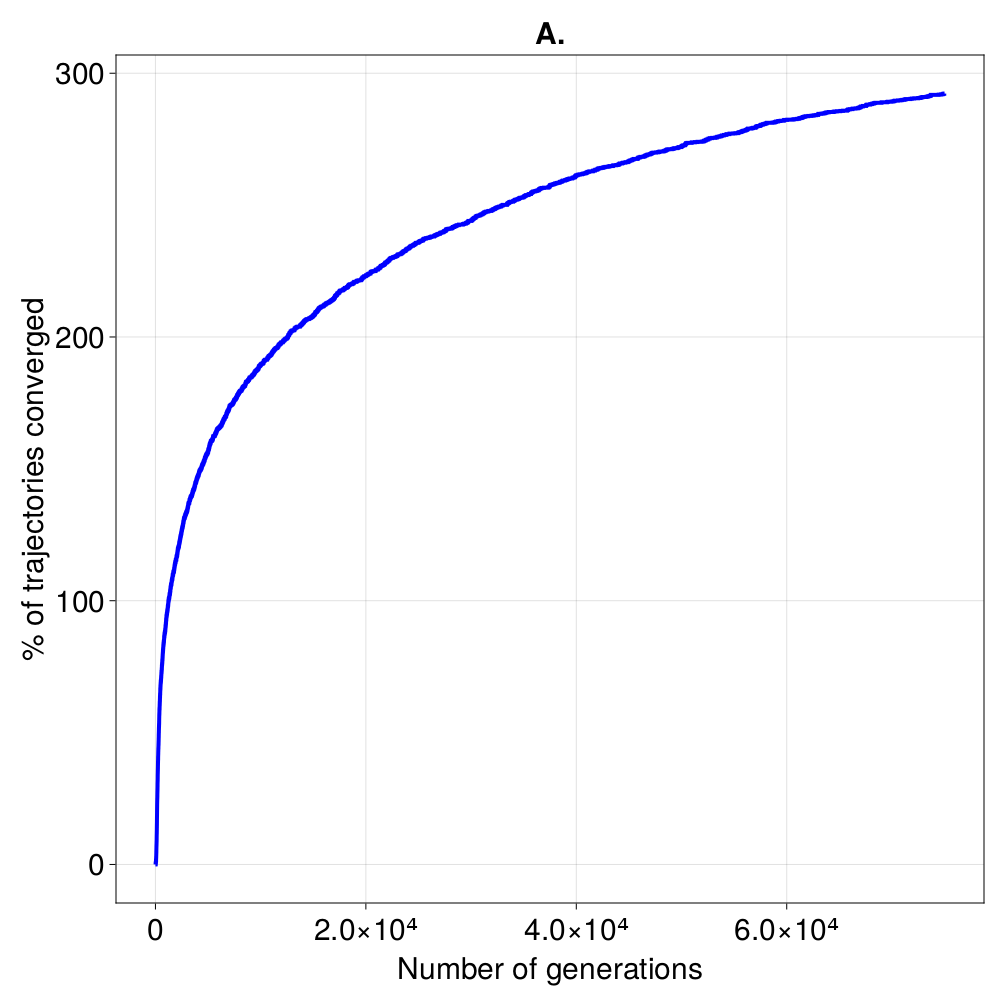

In [52]:
conv_time_fm = map(x->length(x),data_fm["fitness_traj"])

cum_conv_fm = [sum(conv_time_fm .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A.",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv_fm,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

# CairoMakie.save(plotsdirx("MSelection","Convergence.png"),fig)

fig

In [53]:
sim_m_fm = copy(data_fm["fund_dmat_cell"])
conv_fm = copy(data_fm["converged"]);

n_traj_fm = sum(conv_fm)

dmat_av_fm = copy(data_fm["dmat_av"]);

end_networks_fm = map(v->v[:,end],data_fm["geno_traj"]);

In [54]:
mind_class_fm =  map(x->fundamental_labels[x[2]],argmin(sim_m_fm,dims =2)) 

incl_top_fm = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks_fm)) |> transpose |> collect;

dyn_top_mind_fm = zeros(Int,length(end_networks_fm),length(fundamental_topologies))

top_assignment_mind_fm = map(x->fund_top_ndict[x],mind_class_fm)

for (net,t) in enumerate(top_assignment_mind_fm)
    dyn_top_mind_fm[net,t] = 1
end

########

class_labels_fm = map(x->fund_top_dict[x],determine_class(incl_top_fm,dyn_top_mind_fm))[conv_fm];

In [55]:
countmap(class_labels_fm)

Dict{String, Int64} with 5 entries:
  "bistable"      => 342
  "feed_forward"  => 26
  "classical"     => 1431
  "mutual_inh"    => 34
  "No assignment" => 1090

In [56]:
countmap(class_labels)

Dict{String, Int64} with 5 entries:
  "bistable"      => 326
  "feed_forward"  => 25
  "classical"     => 1428
  "mutual_inh"    => 33
  "No assignment" => 1067

In [57]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Comparison of dynamical outcomes, given first mutation = A=>A",xlabel = "Dynamical mechanism",ylabel = "% of trajectories")

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for (n,i) in enumerate([class_labels,class_labels_fm])

    r_ms2_cm = countmap(i)

    count_v = zeros(length(fundamental_topologies)+1)

    for (i,nm) in enumerate(fundamental_topologies)
        if haskey(r_ms2_cm,nm)
            count_v[i+1] = r_ms2_cm[nm]
        else
            count_v[i+1] = 0
        end
    end

    if haskey(r_ms2_cm,"No assignment")
        count_v[1] = r_ms2_cm["No assignment"]
    else
        count_v[1] = 0
    end

    count_v = count_v ./ sum(count_v)

    r_ms3 = reduce(vcat,r[:fitness_delta]);

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(n) for _ in 1:length(count_v)])
    push!(pos_list,collect(1:length(count_v)))
    push!(color_list,[[:cyan,:orange][n] for _ in 1:length(count_v)])

    # CairoMakie.density!(ax3,filter(x->x < 1,r_ms3), color = (cp[fund_top_ndict[i]+1],0.5),offset =  -(fund_top_ndict[i]+1))
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax,xs,ys,dodge = dodge,color = bar_cl)

ax.xticks = (1:6,[fund_top_dict[x] for x in 0:5])

# ax.xticklabelcolor = (1:6,[cp[x+1] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","DynComparisonFirstMut.png"),fig,cond)

fig

ErrorException: type NamedTuple has no field fitness_delta

In [58]:
exp_name = "RE_Minimal_Inhibiting_Single"

data_si = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));



In [59]:
include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))


0.8

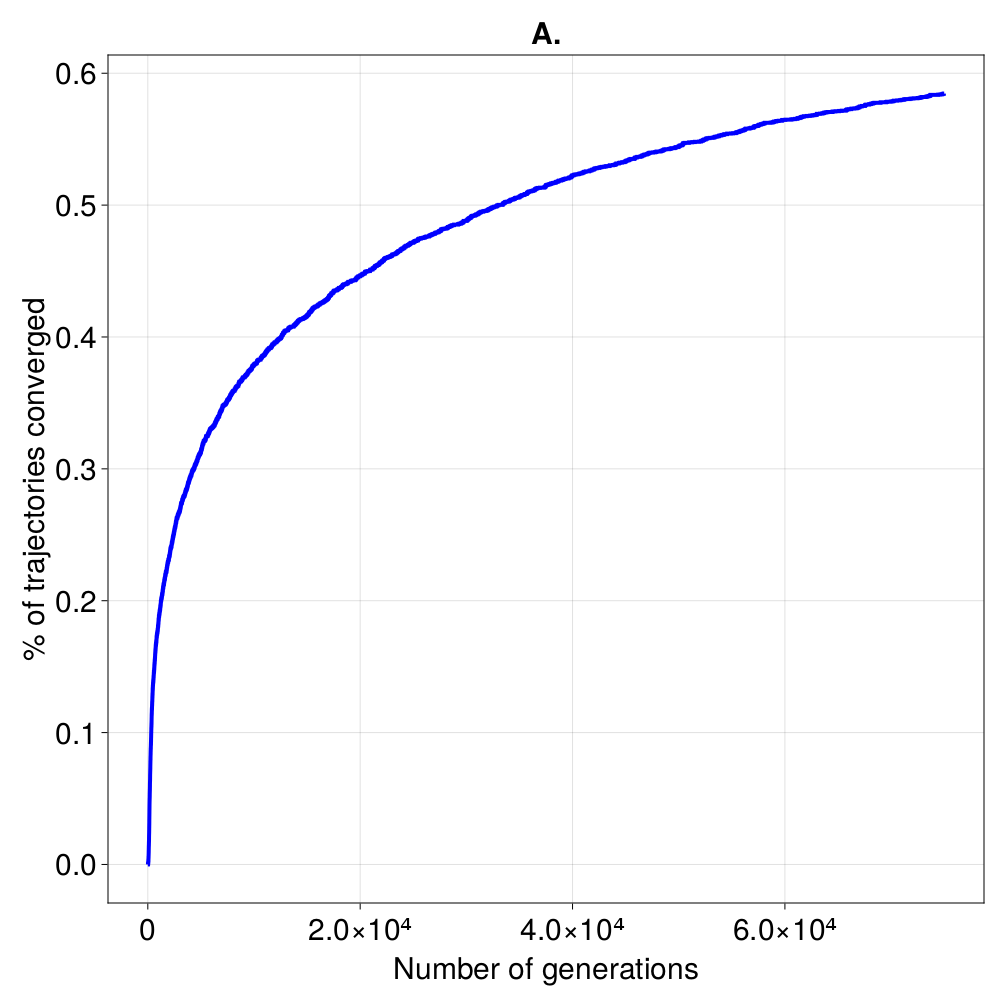

In [60]:
conv_time_si = map(x->length(x),data_si["fitness_traj"])

cum_conv_si = [sum(conv_time_fm .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A.",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv_si,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

# CairoMakie.save(plotsdirx("MSelection","Convergence.png"),fig)

fig

In [61]:
sim_m_si = copy(data_si["fund_dmat_cell"])
conv_si = copy(data["converged"]);

n_traj_si = sum(conv_si)

dmat_av_si = copy(data_si["dmat_av"]);

end_networks_si = map(v->v[:,end],data_si["geno_traj"]);

mind_class_si =  map(x->fundamental_labels[x[2]],argmin(sim_m_si,dims =2)) 

incl_top_si = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks_si)) |> transpose |> collect;

dyn_top_mind_si = zeros(Int,length(end_networks_si),length(fundamental_topologies))

top_assignment_mind_si = map(x->fund_top_ndict[x],mind_class_si)

for (net,t) in enumerate(top_assignment_mind_si)
    dyn_top_mind_si[net,t] = 1
end

########

class_labels_si = map(x->fund_top_dict[x],determine_class(incl_top_si,dyn_top_mind_si))[conv_si];


In [62]:
countmap(class_labels_si)

Dict{String, Int64} with 5 entries:
  "bistable"      => 204
  "feed_forward"  => 2
  "classical"     => 278
  "mutual_inh"    => 1
  "No assignment" => 2394

In [63]:
fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 22.)

ax = Axis(fig[1,1],title = "A. Comparison of dynamical outcomes,multiple mutations vs single mutations",xlabel = "Dynamical mechanism",ylabel = "% of trajectories")

count_v_list = []
dodge_list = []
pos_list = []
color_list = []

for (n,i) in enumerate([class_labels,class_labels_si])

    r_ms2_cm = countmap(i)

    count_v = zeros(length(fundamental_topologies)+1)

    for (i,nm) in enumerate(fundamental_topologies)
        if haskey(r_ms2_cm,nm)
            count_v[i+1] = r_ms2_cm[nm]
        else
            count_v[i+1] = 0
        end
    end

    if haskey(r_ms2_cm,"No assignment")
        count_v[1] = r_ms2_cm["No assignment"]
    else
        count_v[1] = 0
    end

    count_v = count_v ./ sum(count_v)

    r_ms3 = reduce(vcat,r[:fitness_delta]);

    push!(count_v_list,count_v)
    push!(dodge_list,[Int(n) for _ in 1:length(count_v)])
    push!(pos_list,collect(1:length(count_v)))
    push!(color_list,[[:cyan,:grey][n] for _ in 1:length(count_v)])

    # CairoMakie.density!(ax3,filter(x->x < 1,r_ms3), color = (cp[fund_top_ndict[i]+1],0.5),offset =  -(fund_top_ndict[i]+1))
end

xs = reduce(vcat,pos_list)
ys = reduce(vcat,count_v_list)
dodge = reduce(vcat,dodge_list)
bar_cl = reduce(vcat,color_list)

CairoMakie.barplot!(ax,xs,ys,dodge = dodge,color = bar_cl)

ax.xticks = (1:6,[fund_top_dict[x] for x in 0:5])

# ax.xticklabelcolor = (1:6,[cp[x+1] for x in 0:5])

ax.xticklabelrotation = 45

cond_save(plotsdirx("Experiment_1","DynComparisonSingle.png"),fig,cond)

fig

ErrorException: type NamedTuple has no field fitness_delta